## 机器学习课程设计任务
1. 使用机器学习以及人工智能应用课程上学习到的机器学习相关理论与算法，使用CIFAR-10数据训练10分类的机器学习模型。
2. 将学习到的模型部署为一个web-demo：在网页中上传新的图像，显示图像，使用学习到的模型进行预测，输出预测的分类类别。

## 机器学习课程设计要求
1. 熟悉并掌握机器学习全过程：数据准备、模型训练和模型选择、模型测试、模型部署
2. 熟悉sklearn、pytorch机器学习库的使用，掌握使用它们构建模型、解决实际问题的步骤和方法。
3. 要求尝试使用三类模型(算法)进行机器学习，其中至少一种使用sklearn库中的算法，每类模型选择最优参数。然后在三类模型中选择最优模型作为最终模型，最终模型在测试集上的准确率作为评分的依据。
4. 要求使用学习的最优模型，基于streamlit将模型部署为一个web-demo，显示新上传的图像并显示分类结果。

说明（如果不做模型部署则对应相应的低档）：
+ 三个模型全部使用sklearn构建 （仅使用传统机器学习算法-对应D档、C档）
+ 分别使用sklearn和pytorch构建模型（结合使用深度学习算法，对应B档、A档）


## 一、数据读取及显示
CIFAR-10是一个包含60000张32x32彩色图片的数据集，其中包括10个类别的图片，每个类别有6000张图片。这个数据集通常用于图像分类任务的训练和测试。

CIFAR-10数据集的10个类别分别是：飞机、汽车、鸟、猫、鹿、狗、青蛙、马、船和卡车。

关于CIFAR-10数据集的更多信息可以在以下链接找到： https://www.cs.toronto.edu/~kriz/cifar.html

In [2]:
# 标准库
import os
import time
import gc
import pickle

# 数据科学与绘图
import numpy as np
import matplotlib.pyplot as plt

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# PyTorch 核心
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 计算机视觉
from torchvision import datasets, transforms
import timm
import importlib

In [3]:
# 读取CIFAR-10数据集的函数
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
##读取CIFAR-10数据集
data_batch_1 = unpickle('datasets/data_batch_1')
data_batch_2 = unpickle('datasets/data_batch_2')
data_batch_3 = unpickle('datasets/data_batch_3')
data_batch_4 = unpickle('datasets/data_batch_4')
data_batch_5 = unpickle('datasets/data_batch_5')
test_batch = unpickle('datasets/test_batch')

In [5]:
##整合成所需要的数据
x_train = np.concatenate((data_batch_1[b'data'], data_batch_2[b'data'], data_batch_3[b'data'], data_batch_4[b'data'], data_batch_5[b'data']), axis=0)
y_train = np.concatenate((data_batch_1[b'labels'], data_batch_2[b'labels'], data_batch_3[b'labels'], data_batch_4[b'labels'], data_batch_5[b'labels']), axis=0)
x_test = test_batch[b'data']
y_test = np.array(test_batch[b'labels'])

**注意图像数据的组织：**
+ NCHW 中，C 排列在外层，每个通道内像素紧挨在一起，即 ‘RRRRRRGGGGGGBBBBBB’ 这种形式。 
+ NHWC 格式，C 排列在最内层，多个通道对应空间位置的像素紧挨在一起，即 ‘RGBRGBRGBRGBRGBRGB’

Nvidia cudnn以及pytorch使用NCHW的形式，tensorflow默认NHWC的形式（可以设为 NCHW的形式）

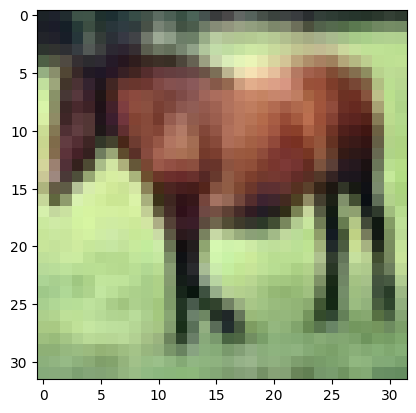

(3072,)
[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [114 117 120 ... 182 192 187]
 [ 76  73  69 ... 127 127 130]
 [ 65  70  76 ...  45  30  21]]
[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6 4 3 6 6 2 6 3 5 4 0 0 9 1 3 4 0 3
 7 3 3 5 2 2 7 1 1 1 2 2 0 9 5 7 9 2 2 5 2 4 3 1 1 8 2]


In [6]:
img=x_train[7].reshape(3,32,32)

plt.imshow(img.transpose((1,2,0)))
plt.show()
print(x_train[7].shape)
print(x_train[0:64])   
print(y_train[0:64])

## 二、数据预处理

### 机器学习可以使用的数据集

In [ ]:
# 1. 数据归一化处理（将像素值从[0,255]归一化到[0,1]）
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 2. 将训练集分成训练集和验证集
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=23101204) ##后面用到的函数中如有"random_state"参数同此处理
print('训练集大小:', x_train.shape, y_train.shape)
print('验证集大小:', x_val.shape, y_val.shape)
print('测试集大小:', x_test.shape, y_test.shape)

# 3. 为sklearn模型准备数据（展平为二维数组）
x_train_sklearn = x_train.reshape(x_train.shape[0], -1)  # (40000, 3072)
x_val_sklearn = x_val.reshape(x_val.shape[0], -1)        # (10000, 3072)
x_test_sklearn = x_test.reshape(x_test.shape[0], -1)      # (10000, 3072)

print('\nsklearn数据格式 - 训练集:', x_train_sklearn.shape)
print('sklearn数据格式 - 验证集:', x_val_sklearn.shape)
print('sklearn数据格式 - 测试集:', x_test_sklearn.shape)

# 4. 为PyTorch模型准备数据（保持为四维张量并转换）
x_train_pytorch = torch.from_numpy(x_train).float()  # 保持NHWC格式 (40000, 32, 32, 3)
x_val_pytorch = torch.from_numpy(x_val).float()
x_test_pytorch = torch.from_numpy(x_test).float()

y_train_pytorch = torch.from_numpy(y_train).long()
y_val_pytorch = torch.from_numpy(y_val).long()
y_test_pytorch = torch.from_numpy(y_test).long()

print('\nPyTorch数据格式 - 训练集:', x_train_pytorch.shape, '标签:', y_train_pytorch.shape)
print('PyTorch数据格式 - 验证集:', x_val_pytorch.shape, '标签:', y_val_pytorch.shape)
print('PyTorch数据格式 - 测试集:', x_test_pytorch.shape, '标签:', y_test_pytorch.shape)

训练集大小: (40000, 3072) (40000,)
验证集大小: (10000, 3072) (10000,)
测试集大小: (10000, 3072) (10000,)

sklearn数据格式 - 训练集: (40000, 3072)
sklearn数据格式 - 验证集: (10000, 3072)
sklearn数据格式 - 测试集: (10000, 3072)

PyTorch数据格式 - 训练集: torch.Size([40000, 3072]) 标签: torch.Size([40000])
PyTorch数据格式 - 验证集: torch.Size([10000, 3072]) 标签: torch.Size([10000])
PyTorch数据格式 - 测试集: torch.Size([10000, 3072]) 标签: torch.Size([10000])


### 具体类别信息

In [8]:
batches_meta=unpickle('datasets/batches.meta')

label_names= batches_meta[b'label_names']
label_names= [name.decode('utf-8') for name in label_names]
label_names=np.array(label_names)
print('分类类别数:', label_names.shape[0])
for index in range(0, label_names.shape[0]):
    print(index, label_names[index])

分类类别数: 10
0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


## 三、模型训练与模型选择
每个人自由选择传统机器学习算法（ML课程中讲到的如）或者人工神经网络（深度学习）的模型,可以使用skearn和pytorch库。
+ K近邻、logistic回归、SVM、决策树、随机森林、梯度boosting等方法 
+ MLP，CNN，Resnet等

1.选择不同的学习算法或模型，或者结合多种算法，完成模型的训练 
2.使用验证集选择不同的模型或者不同的参数





### 模型1 XGBoost的数据准备，模型训练与参数选择

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import time

print("开始训练模型 1: XGBoost")

param_grid = [
    {'n_estimators': 100, 'learning_rate': 0.1},
    {'n_estimators': 200, 'learning_rate': 0.1},
]

best_acc = 0
best_params = None
best_model_xgb = None

for params in param_grid:
    n_trees = params['n_estimators']
    lr = params['learning_rate']

    print(f"\n n_estimators={n_trees}, learning_rate={lr} ...")
    start_time = time.time()

    # 初始化模型
    model_xgb = xgb.XGBClassifier(
        n_estimators=n_trees,
        learning_rate=lr,
        objective='multi:softmax', # 多分类问题
        num_class=10,              # 10 类
        tree_method='hist',        # 使用直方图算法
        device='cuda',             # 使用 GPU
        random_state=23101204,
        early_stopping_rounds=10   # 防止过拟合
    )

    # 训练
    model_xgb.fit(
        x_train_sklearn, y_train,
        eval_set=[(x_val_sklearn, y_val)],
        verbose=10
    )

    # 验证
    val_pred = model_xgb.predict(x_val_sklearn)
    val_acc = accuracy_score(y_val, val_pred)

    end_time = time.time()
    print(f"耗时: {end_time - start_time:.2f} 秒")
    print(f"验证集准确率: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_params = params
        best_model_xgb = model_xgb

print("\n---------------------------------------------------------")
print(f"最佳参数: {best_params}")
print(f"最佳验证集准确率: {best_acc:.4f}")

with open('checkpoints/best_xgboost_cifar10.pkl', 'wb') as f:
    pickle.dump(best_model_xgb, f)
print("XGBoost模型已保存至 checkpoints/best_xgboost_cifar10.pkl")

print("\n最佳模型详细报告:")
print(classification_report(y_val, best_model_xgb.predict(x_val_sklearn), target_names=label_names))

开始训练模型 1: XGBoost
正在使用验证集进行参数选择...

 n_estimators=100, learning_rate=0.1 ...


Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x000002C5D78C6B40>>
Traceback (most recent call last):
  File "C:\Users\15075\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py", line 585, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 
Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x000002C5D78C6B40>>
Traceback (most recent call last):
  File "C:\Users\15075\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py", line 585, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 
Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x000002C5D78C6B40>>


XGBoostError: [09:12:40] C:\actions-runner\_work\xgboost\xgboost\src\data\quantile_dmatrix.cc:174: Check failed: accumulated_rows == info.num_row_ (160000 vs. 40000) : 

### CNN的数据准备，模型训练与CNN参数选择

In [ ]:
# 1. 数据准备 (NCHW 格式)
from models.CNN import CIFAR10_CNN

X_train_cnn = x_train_pytorch.view(-1, 3, 32, 32)
X_val_cnn = x_val_pytorch.view(-1, 3, 32, 32)

# 创建 DataLoader
batch_size = 128
train_dataset = TensorDataset(X_train_cnn, y_train_pytorch)
val_dataset = TensorDataset(X_val_cnn, y_val_pytorch)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"当前设备: {device}")

# 2. 训练配置
epochs = 50
learning_rate = 0.001

model_cnn = CIFAR10_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=learning_rate)

best_acc = 0.0
best_model_cnn = None

print(f"\n开始训练 模型2: CNN (共 {epochs} 轮)...")
print("-" * 50)

for epoch in range(epochs):
    # --- 训练阶段 ---
    model_cnn.train()
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 计算训练集准确率
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = train_correct / train_total

    # --- 验证阶段 ---
    model_cnn.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total

    # 保存最佳模型
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_cnn = model_cnn

    # 每10轮输出一次
    if (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
        print(f"Epoch [{epoch+1}/{epochs}] | 训练Acc: {train_acc:.4f} | 验证Acc: {val_acc:.4f}")

print("-" * 50)
print(f"训练结束。最佳验证集准确率: {best_acc:.4f}")

torch.save(best_model_cnn.state_dict(), 'checkpoints/best_cnn_cifar10.pth')
print("CNN模型已保存至 checkpoints/best_cnn_cifar10.pth")

当前设备: cuda

开始训练 (共 50 轮)...
--------------------------------------------------
Epoch [10/50] | 训练Acc: 0.8161 | 验证Acc: 0.7577
Epoch [20/50] | 训练Acc: 0.9143 | 验证Acc: 0.7878
Epoch [30/50] | 训练Acc: 0.9506 | 验证Acc: 0.7521
Epoch [40/50] | 训练Acc: 0.9654 | 验证Acc: 0.7828
Epoch [50/50] | 训练Acc: 0.9742 | 验证Acc: 0.7816
--------------------------------------------------
训练结束。最佳验证集准确率: 0.7918
CNN模型已保存至 checkpoints/best_cnn_cifar10.pth


### 模型3 ResNet18的数据准备，模型训练与参数选择

In [ ]:
# 1. 数据准备 (NCHW 格式)
from models.ResNet import ResNet18

X_train_res = x_train_pytorch.view(-1, 3, 32, 32)
X_val_res = x_val_pytorch.view(-1, 3, 32, 32)

# 创建 DataLoader
batch_size = 256
train_dataset = TensorDataset(X_train_res, y_train_pytorch)
val_dataset = TensorDataset(X_val_res, y_val_pytorch)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"模型3: ResNet-18 准备就绪 (设备: {device})")

# 2. 训练配置
learning_rate = 0.001
epochs = 30

print(f"\n开始训练 模型3: ResNet-18 (共 {epochs} 轮)...")
print("-" * 50)

model_res = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_res.parameters(), lr=learning_rate)

best_acc = 0.0
best_model_res = None
start_time = time.time()

for epoch in range(epochs):
    # --- 训练阶段 ---
    model_res.train()
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_res(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = train_correct / train_total

    # --- 验证阶段 ---
    model_res.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_res(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total

    # 保存最佳模型
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_res = model_res

    # 每5轮输出一次
    if (epoch + 1) % 5 == 0 or (epoch + 1) == epochs:
        print(f"Epoch [{epoch+1}/{epochs}] | 训练Acc: {train_acc:.4f} | 验证Acc: {val_acc:.4f}")

print("-" * 50)
print(f"训练结束。ResNet-18 最佳验证集准确率: {best_acc:.4f}")

torch.save(best_model_res.state_dict(), 'checkpoints/best_resnet18_cifar10.pth')
print("ResNet-18模型已保存至 checkpoints/best_resnet18_cifar10.pth")

模型3: ResNet-18 准备就绪 (设备: cuda)

开始训练 模型3: ResNet-18 (共 30 轮)...
--------------------------------------------------


KeyboardInterrupt: 

## air_bench94模型4

In [ ]:
# 模型4: Airbench94 训练
import importlib
import models.Airbench
importlib.reload(models.Airbench)
from models.Airbench import CifarNet
from models.Muon import Muon
import time

device = torch.device("cuda")
torch.backends.cudnn.benchmark = True

# CIFAR-10 归一化
CIFAR_MEAN = torch.tensor((0.4914, 0.4822, 0.4465), device=device).view(1, 3, 1, 1).half()
CIFAR_STD = torch.tensor((0.2470, 0.2435, 0.2616), device=device).view(1, 3, 1, 1).half()

def normalize(x):
    return (x - CIFAR_MEAN) / CIFAR_STD

def batch_flip_lr(inputs):
    """随机左右翻转"""
    flip_mask = (torch.rand(len(inputs), device=inputs.device) < 0.5).view(-1, 1, 1, 1)
    return torch.where(flip_mask, inputs.flip(-1), inputs)

def batch_crop(images, crop_size=32, pad=2):
    """随机裁剪"""
    padded = F.pad(images, (pad, pad, pad, pad), mode='reflect')
    b, c, h, w = padded.shape
    # 随机偏移
    offset_y = torch.randint(0, 2*pad+1, (b,), device=images.device)
    offset_x = torch.randint(0, 2*pad+1, (b,), device=images.device)
    # 裁剪
    cropped = torch.zeros_like(images)
    for i in range(b):
        cropped[i] = padded[i, :, offset_y[i]:offset_y[i]+crop_size, offset_x[i]:offset_x[i]+crop_size]
    return cropped

def infer_tta(model, images):
    """测试时增强 (TTA)"""
    logits = model(images)
    logits_flip = model(images.flip(-1))
    return 0.5 * logits + 0.5 * logits_flip

# 数据准备 - 半精度 + channels_last
X_train_air = x_train_pytorch.view(-1, 3, 32, 32).half().to(device).to(memory_format=torch.channels_last)
X_val_air = x_val_pytorch.view(-1, 3, 32, 32).half().to(device).to(memory_format=torch.channels_last)
y_train_air = y_train_pytorch.to(device)
y_val_air = y_val_pytorch.to(device)

batch_size = 1000
train_dataset = TensorDataset(X_train_air, y_train_air)
val_dataset = TensorDataset(X_val_air, y_val_air)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 初始化模型
model_air = CifarNet().to(device).to(memory_format=torch.channels_last)
model_air.reset()
train_images_norm = normalize(X_train_air[:5000])
model_air.init_whiten(train_images_norm)

# 双优化器配置
bias_lr = 0.053
head_lr = 0.67
wd = 2e-6 * batch_size

filter_params = [p for p in model_air.parameters() if len(p.shape) == 4 and p.requires_grad]
norm_biases = [p for n, p in model_air.named_parameters() if "norm" in n and p.requires_grad]

optimizer1 = torch.optim.SGD([
    dict(params=[model_air.whiten.bias], lr=bias_lr, weight_decay=wd/bias_lr),
    dict(params=norm_biases, lr=bias_lr, weight_decay=wd/bias_lr),
    dict(params=[model_air.head.weight], lr=head_lr, weight_decay=wd/head_lr),
], momentum=0.85, nesterov=True)

optimizer2 = Muon(filter_params, lr=0.24, momentum=0.6, nesterov=True)

epochs = 10
total_steps = epochs * len(train_loader)
whiten_bias_steps = 3 * len(train_loader)

best_acc = 0.0
step = 0
start_time = time.time()

print(f"模型4: CifarNet94 准备就绪")
print(f"开始训练 (共 {epochs} 轮)...")
print("-" * 50)

for epoch in range(epochs):
    model_air.train()
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        # 数据增强：归一化 + 随机翻转 + 随机裁剪
        images = normalize(images)
        images = batch_flip_lr(images)
        images = batch_crop(images, crop_size=32, pad=2)

        # 学习率调度
        for group in optimizer1.param_groups[:1]:
            group["lr"] = bias_lr * max(0, 1 - step / whiten_bias_steps)
        for group in optimizer1.param_groups[1:]:
            group["lr"] = group.get("initial_lr", bias_lr) * (1 - step / total_steps)
        for group in optimizer2.param_groups:
            group["lr"] = 0.24 * (1 - step / total_steps)

        outputs = model_air(images, whiten_bias_grad=(step < whiten_bias_steps))
        loss = F.cross_entropy(outputs, labels, label_smoothing=0.2, reduction="sum")

        loss.backward()
        optimizer1.step()
        optimizer2.step()
        model_air.zero_grad(set_to_none=True)

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        step += 1

    train_acc = train_correct / train_total

    # 验证
    model_air.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = normalize(images)
            outputs = infer_tta(model_air, images)  # TTA
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = val_correct / val_total

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model_air.state_dict(), 'checkpoints/best_airbench_cifar10.pth')
        print(f"  -> 保存最佳模型")

    print(f"Epoch [{epoch+1}/{epochs}] | 训练Acc: {train_acc:.4f} | 验证Acc: {val_acc:.4f}")

print("-" * 50)
print(f"最佳验证集准确率: {best_acc:.4f}")
print(f"耗时: {time.time() - start_time:.1f}秒")

模型4: CifarNet 准备就绪 (带数据增强+TTA)
开始训练 (共 10 轮)...
--------------------------------------------------
  -> 保存最佳模型
Epoch [1/10] | 训练Acc: 0.6081 | 验证Acc: 0.4626
  -> 保存最佳模型
Epoch [2/10] | 训练Acc: 0.7780 | 验证Acc: 0.6984
  -> 保存最佳模型
Epoch [3/10] | 训练Acc: 0.8094 | 验证Acc: 0.8026
Epoch [4/10] | 训练Acc: 0.8386 | 验证Acc: 0.7899
  -> 保存最佳模型
Epoch [5/10] | 训练Acc: 0.8622 | 验证Acc: 0.8153
  -> 保存最佳模型
Epoch [6/10] | 训练Acc: 0.8847 | 验证Acc: 0.8273
  -> 保存最佳模型
Epoch [7/10] | 训练Acc: 0.9060 | 验证Acc: 0.8906
  -> 保存最佳模型
Epoch [8/10] | 训练Acc: 0.9324 | 验证Acc: 0.9109
  -> 保存最佳模型
Epoch [9/10] | 训练Acc: 0.9585 | 验证Acc: 0.9228
  -> 保存最佳模型
Epoch [10/10] | 训练Acc: 0.9771 | 验证Acc: 0.9334
--------------------------------------------------
最佳验证集准确率: 0.9334
耗时: 93.5秒


In [ ]:
# 模型5: CifarNet96
import importlib
import gc
gc.collect()
torch.cuda.empty_cache()

import models.Airbench96
importlib.reload(models.Airbench96)
from models.Airbench96 import CifarNet96, batch_flip_lr, batch_crop, batch_cutout, infer_tta
import time

device = torch.device("cuda")
torch.backends.cudnn.benchmark = True

CIFAR_MEAN = torch.tensor((0.4914, 0.4822, 0.4465), device=device).view(1, 3, 1, 1).half()
CIFAR_STD = torch.tensor((0.2470, 0.2435, 0.2616), device=device).view(1, 3, 1, 1).half()

def normalize(x):
    return (x - CIFAR_MEAN) / CIFAR_STD

# 数据准备
X_train_96 = x_train_pytorch.view(-1, 3, 32, 32).half().to(device).to(memory_format=torch.channels_last)
X_val_96 = x_val_pytorch.view(-1, 3, 32, 32).half().to(device).to(memory_format=torch.channels_last)
y_train_96 = y_train_pytorch.to(device)
y_val_96 = y_val_pytorch.to(device)


batch_size = 1024
batch_size_masked = 512  # 只训练loss最高的512个
train_dataset = TensorDataset(X_train_96, y_train_96)
val_dataset = TensorDataset(X_val_96, y_val_96)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 模型初始化
model_96 = CifarNet96().to(device).to(memory_format=torch.channels_last)
model_96.reset()
train_images_norm = normalize(X_train_96[:5000])
model_96.init_whiten(train_images_norm)

print(f"CifarNet96 参数量: {sum(p.numel() for p in model_96.parameters()):,}")

# 原版超参数
epochs = 45
momentum = 0.85
kilostep_scale = 1024 * (1 + 1 / (1 - momentum))
lr = 9.0 / kilostep_scale
wd = 0.012 * batch_size / kilostep_scale
lr_biases = lr * 64.0
whiten_bias_epochs = 3

# 分组参数
norm_biases = [p for n, p in model_96.named_parameters() if 'norm' in n and p.requires_grad]
other_params = [p for n, p in model_96.named_parameters() if 'norm' not in n and p.requires_grad]
param_configs = [
    dict(params=norm_biases, lr=lr_biases, weight_decay=wd/lr_biases),
    dict(params=other_params, lr=lr, weight_decay=wd/lr)
]
optimizer = torch.optim.SGD(param_configs, momentum=momentum, nesterov=True)

# 学习率调度
steps_per_epoch = len(train_loader)
total_train_steps = steps_per_epoch * epochs
warmup_steps = int(total_train_steps * 0.1)

def get_lr_mult(step):
    if step < warmup_steps:
        return 0.2 + 0.8 * (step / warmup_steps)
    else:
        return (total_train_steps - step) / (total_train_steps - warmup_steps)

# Lookahead EMA
class LookaheadState:
    def __init__(self, net):
        self.net_ema = {k: v.clone() for k, v in net.state_dict().items()}
    def update(self, net, decay):
        for ema_param, net_param in zip(self.net_ema.values(), net.state_dict().values()):
            if net_param.dtype in (torch.half, torch.float):
                ema_param.lerp_(net_param, 1-decay)
                net_param.copy_(ema_param)

alpha_schedule = 0.95**5 * (torch.arange(total_train_steps+1) / total_train_steps)**3
lookahead = LookaheadState(model_96)

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.2, reduction='none')
best_acc = 0.0
step = 0
start_time = time.time()

# 预pad数据用于crop
pad = 4

X_train_padded = F.pad(normalize(X_train_96), (pad,)*4, 'reflect')

print(f"开始训练 (共 {epochs} 轮, batch={batch_size})...")
print("-" * 60)

for epoch in range(epochs):
    model_96.train()
    train_correct = 0
    train_total = 0

    # 每epoch随机打乱
    perm = torch.randperm(len(X_train_96), device=device)

    for i in range(0, len(X_train_96), batch_size):
        if i + batch_size > len(X_train_96):
            break

        indices = perm[i:i+batch_size]
        images = X_train_padded[indices]
        labels = y_train_96[indices]

        # 数据增强: crop from padded
        r = pad
        shifts = torch.randint(-r, r+1, size=(len(images), 2), device=device)
        images_cropped = torch.empty((len(images), 3, 32, 32), device=device, dtype=images.dtype)
        for sy in range(-r, r+1):
            for sx in range(-r, r+1):
                mask = (shifts[:, 0] == sy) & (shifts[:, 1] == sx)
                if mask.any():
                    images_cropped[mask] = images[mask, :, r+sy:r+sy+32, r+sx:r+sx+32]

        # 交替翻转 (alternating flip)
        if epoch % 2 == 1:
            images_cropped = images_cropped.flip(-1)

        # Cutout
        images_cropped = batch_cutout(images_cropped, size=12)

        # 学习率调度
        lr_mult = get_lr_mult(step)
        for g in optimizer.param_groups:
            g['lr'] = g['initial_lr'] * lr_mult if 'initial_lr' in g else lr_biases * lr_mult
        optimizer.param_groups[0]['lr'] = lr_biases * lr_mult
        optimizer.param_groups[1]['lr'] = lr * lr_mult

        # 前向传播
        whiten_bias_grad = (epoch < whiten_bias_epochs)
        outputs = model_96(images_cropped, whiten_bias_grad=whiten_bias_grad)
        loss_all = loss_fn(outputs, labels)

        # Hard Sample Mining: 只训练loss最高的batch_size_masked个
        mask = torch.zeros(len(images_cropped), device=device, dtype=torch.bool)
        mask[loss_all.argsort()[-batch_size_masked:]] = True
        loss = loss_all[mask].sum()

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # Lookahead更新
        step += 1
        if step % 5 == 0:
            lookahead.update(model_96, decay=alpha_schedule[step].item())

        _, predicted = torch.max(outputs[mask].data, 1)
        train_total += mask.sum().item()
        train_correct += (predicted == labels[mask]).sum().item()

    # 最后一步Lookahead
    if epoch == epochs - 1:
        lookahead.update(model_96, decay=1.0)

    train_acc = train_correct / train_total

    # 验证
    model_96.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = normalize(images)
            outputs = infer_tta(model_96, images, tta_level=2)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = val_correct / val_total

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model_96.state_dict(), 'checkpoints/best_airbench96_cifar10.pth')

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | 训练Acc: {train_acc:.4f} | 验证Acc(TTA): {val_acc:.4f}")

print("-" * 60)
print(f"最佳验证集准确率: {best_acc:.4f}")
print(f"耗时: {time.time() - start_time:.1f}秒")

CifarNet96 参数量: 9,918,776
开始训练 (共 50 轮, batch=1024)...
------------------------------------------------------------
Epoch [5/50] | 训练Acc: 0.2422 | 验证Acc(TTA): 0.2654
Epoch [10/50] | 训练Acc: 0.4650 | 验证Acc(TTA): 0.4716
Epoch [15/50] | 训练Acc: 0.6710 | 验证Acc(TTA): 0.7304
Epoch [20/50] | 训练Acc: 0.7305 | 验证Acc(TTA): 0.7950
Epoch [25/50] | 训练Acc: 0.7790 | 验证Acc(TTA): 0.8160
Epoch [30/50] | 训练Acc: 0.8193 | 验证Acc(TTA): 0.8318
Epoch [35/50] | 训练Acc: 0.8456 | 验证Acc(TTA): 0.8856
Epoch [40/50] | 训练Acc: 0.8771 | 验证Acc(TTA): 0.9128
Epoch [45/50] | 训练Acc: 0.9116 | 验证Acc(TTA): 0.9282
Epoch [50/50] | 训练Acc: 0.9467 | 验证Acc(TTA): 0.9408
------------------------------------------------------------
最佳验证集准确率: 0.9408
耗时: 898.1秒


## 四、模型测试
+ 使用上面的模型在分别在测试集上测试，输出准确率，找到最优模型。
+ 将最优模型保存为文件，方便后续的模型部署。
    sklearn 参考： https://scikit-learn.org/stable/model_persistence.html
    pytroch 参考： https://pytorch.org/tutorials/beginner/saving_loading_models.html
+ 输出最优模型的准确率，作为评分依据之一。

In [ ]:
with open("checkpoints/best_xgboost_cifar10.pkl", "rb") as f:
    best_model_xgb = pickle.load(f)
print("XGBoost模型已加载")

# ==================== 模型测试 ====================
print("\n" + "=" * 60)
print("模型测试结果")
print("=" * 60)

test_pred_xgb = best_model_xgb.predict(x_test_sklearn)
acc_xgb = accuracy_score(y_test, test_pred_xgb)
print(f"模型1 XGBoost 测试集准确率: {acc_xgb:.4f}")

XGBoost模型已加载

模型测试结果
模型1 XGBoost 测试集准确率: 0.5371


In [ ]:
from models.CNN import CIFAR10_CNN

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_model_cnn = CIFAR10_CNN().to(device)
best_model_cnn.load_state_dict(torch.load("checkpoints/best_cnn_cifar10.pth",weights_only=True))
print("CNN模型已加载")

X_test_cnn = torch.from_numpy(x_test).float().view(-1, 3, 32, 32).to(device)
y_test_tensor = torch.from_numpy(y_test).long().to(device)

best_model_cnn.eval()
with torch.no_grad():
    outputs = best_model_cnn(X_test_cnn)
    _, predicted = torch.max(outputs, 1)
    acc_cnn = (predicted == y_test_tensor).sum().item() / len(y_test)

print(f"模型2 CNN 测试集准确率: {acc_cnn:.4f}")

CNN模型已加载
模型2 CNN 测试集准确率: 0.7802


In [ ]:
from models.ResNet import ResNet18

best_model_res = ResNet18().to(device)
best_model_res.load_state_dict(torch.load("checkpoints/best_resnet18_cifar10.pth", weights_only=True))
print("ResNet-18模型已加载")

best_model_res.eval()
with torch.no_grad():
    outputs = best_model_res(X_test_cnn)
    _, predicted = torch.max(outputs, 1)
    acc_res = (predicted == y_test_tensor).sum().item() / len(y_test)
print(f"模型3 ResNet-18 测试集准确率: {acc_res:.4f}")

ResNet-18模型已加载
模型3 ResNet-18 测试集准确率: 0.8185


In [17]:
# 读取评测 CifarNet 模型 (93%版本)
import importlib
import models.Airbench
importlib.reload(models.Airbench)
from models.Airbench import CifarNet

device = torch.device("cuda")

CIFAR_MEAN = torch.tensor((0.4914, 0.4822, 0.4465), device=device).view(1, 3, 1, 1).half()
CIFAR_STD = torch.tensor((0.2470, 0.2435, 0.2616), device=device).view(1, 3, 1, 1).half()

def normalize(x):
    return (x - CIFAR_MEAN) / CIFAR_STD

# 加载模型
model_air = CifarNet().to(device).to(memory_format=torch.channels_last)
model_air.load_state_dict(torch.load('checkpoints/best_airbench_cifar10.pth', weights_only=True))
model_air.eval()

print(f"CifarNet 参数量: {sum(p.numel() for p in model_air.parameters()):,}")

# 准备测试数据
X_test = x_test_pytorch.view(-1, 3, 32, 32).half().to(device).to(memory_format=torch.channels_last)
y_test = y_test_pytorch.to(device)

# 评估
correct = 0
total = 0
with torch.no_grad():
    for i in range(0, len(X_test), 500):
        images = normalize(X_test[i:i+500])
        labels = y_test[i:i+500]
        outputs = model_air(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"CifarNet 测试集准确率: {test_acc:.4f}")

CifarNet 参数量: 1,972,792
CifarNet 测试集准确率: 0.9243


In [16]:
# 读取评测 CifarNet96 模型
import importlib
import models.Airbench96
importlib.reload(models.Airbench96)
from models.Airbench96 import CifarNet96, infer_tta

device = torch.device("cuda")

CIFAR_MEAN = torch.tensor((0.4914, 0.4822, 0.4465), device=device).view(1, 3, 1, 1).half()
CIFAR_STD = torch.tensor((0.2470, 0.2435, 0.2616), device=device).view(1, 3, 1, 1).half()

def normalize(x):
    return (x - CIFAR_MEAN) / CIFAR_STD

# 加载模型
model_96 = CifarNet96().to(device).to(memory_format=torch.channels_last)
model_96.load_state_dict(torch.load('checkpoints/best_airbench96_cifar10.pth', weights_only=True))
model_96.eval()

print(f"CifarNet96 参数量: {sum(p.numel() for p in model_96.parameters()):,}")

# 准备测试数据
X_test = x_test_pytorch.view(-1, 3, 32, 32).half().to(device).to(memory_format=torch.channels_last)
y_test = y_test_pytorch.to(device)

# 评估 (带TTA)
correct = 0
total = 0
with torch.no_grad():
    for i in range(0, len(X_test), 500):
        images = normalize(X_test[i:i+500])
        labels = y_test[i:i+500]
        outputs = infer_tta(model_96, images, tta_level=2)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"CifarNet96 测试集准确率 (TTA): {test_acc:.4f}")

CifarNet96 参数量: 9,918,776
CifarNet96 测试集准确率 (TTA): 0.9558


## EVA模型

In [10]:
# 读取评测 EVA-02 模型
import warnings
warnings.filterwarnings('ignore')

from EVA import modeling_finetune
from timm.models import create_model
from torchvision import transforms

device = torch.device("cuda")

# EVA 配置
MODEL_NAME = 'eva02_base_patch14_xattn_fusedLN_NaiveSwiGLU_subln_RoPE'
INPUT_SIZE = 224
NUM_CLASSES = 10

MEAN = (0.48145466, 0.4578275, 0.40821073)
STD = (0.26862954, 0.26130258, 0.27577711)

# 图像预处理 (32->224)
transform_eva = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(INPUT_SIZE),
    transforms.Normalize(MEAN, STD),
])

# 加载模型
model_eva = create_model(MODEL_NAME, pretrained=False, num_classes=NUM_CLASSES,
                         drop_rate=0.0, drop_path_rate=0.0, attn_drop_rate=0.0, use_mean_pooling=True)
checkpoint = torch.load('checkpoints/best_eva_cifar10.pth', map_location='cpu', weights_only=False)
state_dict = checkpoint['model'] if 'model' in checkpoint else checkpoint
model_eva.load_state_dict(state_dict, strict=False)
model_eva = model_eva.to(device).eval()

print(f"EVA-02 参数量: {sum(p.numel() for p in model_eva.parameters()):,}")

# 准备测试数据
X_test_eva = x_test_pytorch.view(-1, 3, 32, 32).float().to(device)

# 评估
correct = 0
total = 0
with torch.no_grad():
    for i in range(0, len(X_test_eva), 32):
        images = X_test_eva[i:i+32]
        labels = y_test_pytorch[i:i+32].to(device)
        # Resize + Normalize
        images = F.interpolate(images, size=224, mode='bilinear', align_corners=False)
        images = (images - torch.tensor(MEAN, device=device).view(1,3,1,1)) / torch.tensor(STD, device=device).view(1,3,1,1)
        outputs = model_eva(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"EVA-02 测试集准确率: {test_acc:.4f}")

======== shape of rope freq torch.Size([256, 64]) ========
EVA-02 参数量: 85,766,410
EVA-02 测试集准确率: 0.9879


## 五、模型部署
自行学习streamlit的使用以及编程方法

使用上面训练得到的模型，采用[streamlit](https://streamlit.io/)构建一个web demo, 上传图像，输出图像对应的分类名称。
参考：
+ [Streamlit documentation](https://docs.streamlit.io/)
+ https://stevensmiley1989.medium.com/train-deploy-yolov7-to-streamlit-5a3e925690a9